<a href="https://colab.research.google.com/github/Venkatpolavarapu/Data-Science/blob/master/MLOPS1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
! git clone https://github.com/https-deeplearning-ai/MLEP-public.git


Cloning into 'MLEP-public'...
remote: Enumerating objects: 236, done.
remote: Total 236 (delta 0), reused 0 (delta 0), pack-reused 236
Receiving objects: 100% (236/236), 18.15 MiB | 19.34 MiB/s, done.
Resolving deltas: 100% (96/96), done.


In [16]:
cd MLEP-public/course1/week1-ungraded-lab


/content/MLEP-public/course1/week1-ungraded-lab/MLEP-public/course1/week1-ungraded-lab


In [17]:
pip install -r requirements.txt


In [18]:
from IPython.display import Image, display


Displaying image: apple.jpg


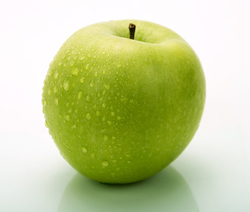


Displaying image: clock.jpg


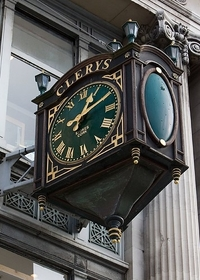


Displaying image: oranges.jpg


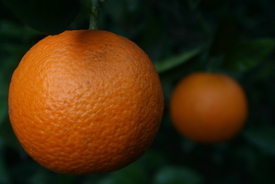


Displaying image: car.jpg


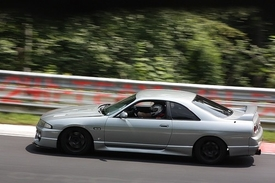

In [19]:
# Some example images
image_files = [
    'apple.jpg',
    'clock.jpg',
    'oranges.jpg',
    'car.jpg'
]

for image_file in image_files:
    print(f"\nDisplaying image: {image_file}")
    display(Image(filename=f"images/{image_file}"))

In [20]:
import os

dir_name = "images_with_boxes"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

In [21]:
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox


def detect_and_draw_box(filename, model="yolov3-tiny", confidence=0.5):
    """Detects common objects on an image and creates a new image with bounding boxes.

    Args:
        filename (str): Filename of the image.
        model (str): Either "yolov3" or "yolov3-tiny". Defaults to "yolov3-tiny".
        confidence (float, optional): Desired confidence level. Defaults to 0.5.
    """
    
    # Images are stored under the images/ directory
    img_filepath = f'images/{filename}'
    
    # Read the image into a numpy array
    img = cv2.imread(img_filepath)
    
    # Perform the object detection
    bbox, label, conf = cv.detect_common_objects(img, confidence=confidence, model=model)
    
    # Print current image's filename
    print(f"========================\nImage processed: {filename}\n")
    
    # Print detected objects with confidence level
    for l, c in zip(label, conf):
        print(f"Detected object: {l} with confidence level of {c}\n")
    
    # Create a new image that includes the bounding boxes
    output_image = draw_bbox(img, bbox, label, conf)
    
    # Save the image in the directory images_with_boxes
    cv2.imwrite(f'images_with_boxes/{filename}', output_image)
    
    # Display the image with bounding boxes
    display(Image(f'images_with_boxes/{filename}'))

Image processed: apple.jpg

Detected object: apple with confidence level of 0.5717206597328186



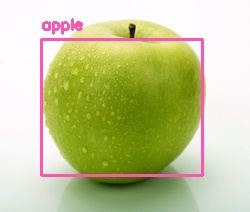

Image processed: clock.jpg

Detected object: clock with confidence level of 0.9683184623718262



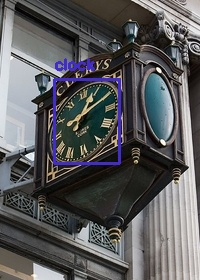

Image processed: oranges.jpg

Detected object: orange with confidence level of 0.6185588836669922

Detected object: orange with confidence level of 0.5561690330505371



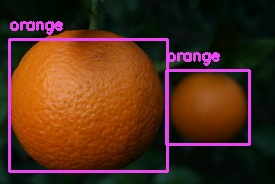

Image processed: car.jpg

Detected object: car with confidence level of 0.6325406432151794



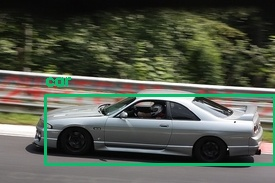

In [22]:
for image_file in image_files:
    detect_and_draw_box(image_file)

Image processed: fruits.jpg

Detected object: apple with confidence level of 0.5818482041358948

Detected object: orange with confidence level of 0.5346484184265137

Detected object: orange with confidence level of 0.515099287033081



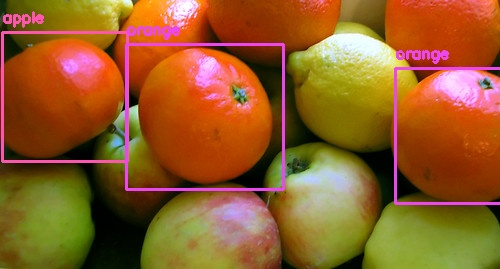

In [23]:
detect_and_draw_box("fruits.jpg")

Image processed: fruits.jpg

Detected object: apple with confidence level of 0.5818482041358948

Detected object: orange with confidence level of 0.5346484184265137

Detected object: orange with confidence level of 0.515099287033081

Detected object: apple with confidence level of 0.34759870171546936

Detected object: orange with confidence level of 0.32876086235046387

Detected object: apple with confidence level of 0.31244686245918274

Detected object: orange with confidence level of 0.27986079454421997

Detected object: orange with confidence level of 0.2749977707862854

Detected object: apple with confidence level of 0.2744504511356354

Detected object: orange with confidence level of 0.21419058740139008



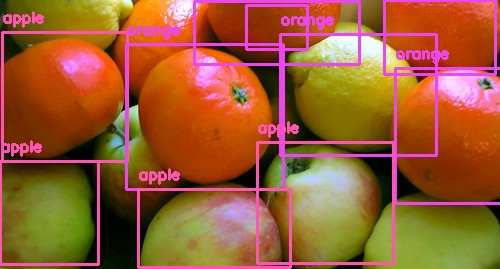

In [24]:
detect_and_draw_box("fruits.jpg", confidence=0.2)

In [25]:
dir_name = "images_uploaded"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

In [26]:
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse

In [27]:
!pip install pyngrok --quiet
from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = ""
ngrok.set_auth_token("1wDmrNeJV9HslkGWy5sMqg4LHfU_3rTAoGdQZEquZoqNHKzcp")

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
public_url = ngrok.connect(port="8000", proto="http", options={"bind_tls": True})
print("Tracking URL:", public_url)

Tracking URL: NgrokTunnel: "http://610ee1550e4c.ngrok.io" -> "http://localhost:80"


In [28]:
# Assign an instance of the FastAPI class to the variable "app".
# You will interact with your api using this instance.
app = FastAPI(title='Deploying a ML Model with FastAPI')

# List available models using Enum for convenience. This is useful when the options are pre-defined.
class Model(str, Enum):
    yolov3tiny = "yolov3-tiny"
    yolov3 = "yolov3"


# By using @app.get("/") you are allowing the GET method to work for the / endpoint.
@app.get("/")
def home():
    return "Congratulations! Your API is working as expected. Now head over to http://localhost:8000/docs."


# This endpoint handles all the logic necessary for the object detection to work.
# It requires the desired model and the image in which to perform object detection.
@app.post("/predict") 
def prediction(model: Model, file: UploadFile = File(...)):

    # 1. VALIDATE INPUT FILE
    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="Unsupported file provided.")
    
    # 2. TRANSFORM RAW IMAGE INTO CV2 image
    
    # Read image as a stream of bytes
    image_stream = io.BytesIO(file.file.read())
    
    # Start the stream from the beginning (position zero)
    image_stream.seek(0)
    
    # Write the stream of bytes into a numpy array
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    
    # Decode the numpy array as an image
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    
    # 3. RUN OBJECT DETECTION MODEL
    
    # Run object detection
    bbox, label, conf = cv.detect_common_objects(image, model=model)
    
    # Create image that includes bounding boxes and labels
    output_image = draw_bbox(image, bbox, label, conf)
    
    # Save it in a folder within the server
    cv2.imwrite(f'images_uploaded/{filename}', output_image)
    
    
    # 4. STREAM THE RESPONSE BACK TO THE CLIENT
    
    # Open the saved image for reading in binary mode
    file_image = open(f'images_uploaded/{filename}', mode="rb")
    
    # Return the image as a stream specifying media type
    return StreamingResponse(file_image, media_type="image/jpeg")

In [ ]:
# Allows the server to be run in this interactive environment
nest_asyncio.apply()

# Host depends on the setup you selected (docker or virtual env)
host = "0.0.0.0" if os.getenv("DOCKER-SETUP") else "127.0.0.1"

# Spin up the server!    
uvicorn.run(app, host=host, port=8000)